In [15]:
# import packages
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import shap
import matplotlib.pyplot as plt

In [4]:
seed = 2724

### Import data

In [5]:
DF_PATH = "mod04_data/sample.csv"
df = pd.read_csv(DF_PATH)

### Separate data by independent (X) and dependent (y) variables

In [6]:
X = df[["income", "education_years", "zipcode_score"]]
y = df["target"]

### Split the data into a _training_ set (to build a model) and _test_ set (to validate a model)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed
)

### Build a model on the training set

In [8]:
model = RandomForestRegressor(
    n_estimators=200,
    random_state=seed
)
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=2724)

### Use SHAP to explain the model on test data

In [9]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

 99%|===================| 1480/1500 [01:05<00:00]        

This will allow us to see which variables are most important to predicting the outcome.

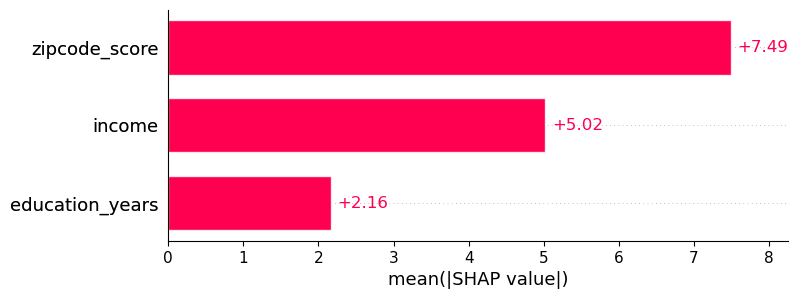

In [10]:
shap.plots.bar(shap_values)

### Import the `group` variable, which was **not** used in training this model.

In [11]:
X_test_with_group = X_test.copy()
X_test_with_group["group"] = df.loc[X_test.index, "group"]

### Look at the difference in SHAP values between the two groups across the variables used in the model.

In [12]:
shap_df = pd.DataFrame(shap_values.values, columns=X_test.columns)
shap_df["group"] = X_test_with_group["group"].values

shap_df.groupby("group").mean()

,income,education_years,zipcode_score
group,,,
0,1.086254,-0.170779,5.866534
1,1.020094,-0.192841,-6.859435


### Let's put `group` and `zipcode_score` in the same plot

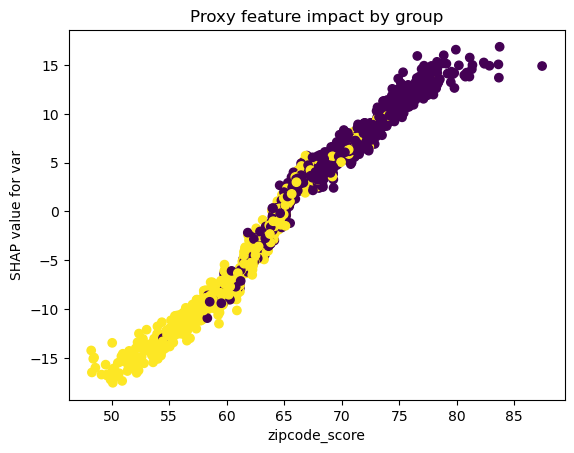

In [13]:
def plot_shap(var):
    # Extract SHAP values for the feature
    shap_var = shap_values[:, var].values

    # Plot the values of each group using different colors
    plt.figure()
    plt.scatter(
        X_test[var],
        shap_var,
        c=X_test_with_group["group"]
    )
    plt.xlabel(var)
    plt.ylabel(f"SHAP value for var")
    plt.title("Proxy feature impact by group")
    plt.show()

plot_shap("zipcode_score")

# Discussion Questions

### What is a _SHAP_ (or Shapley) value? 

A shapely value is a measure of an individuals's average influence on the prediction model for all possible coalitions of features from the dataset.  

### Suppose you built this model and then it is peer reviewed by another entity. If the reviewer asks whether you used the variable `group` in your model, what would your answer be?

No, because only ["income", "education_years", "zipcode_score"] are used to predict the vlaue of the target feature.  group is only used to compare the shap values of individuals from group 0 and individuals from group 1.  

### If the reviewer asks whether the outcome of your model is correlated with `group`, what would your answer be?

Yes, because zipcode_score, one of the predictors, is correlated with group which leads to the outcome of the model to be correlated with group.  

### Construct a "proxy feature impact by group" plot for `income`. How is this plot different from the one for `zipcode_score`?

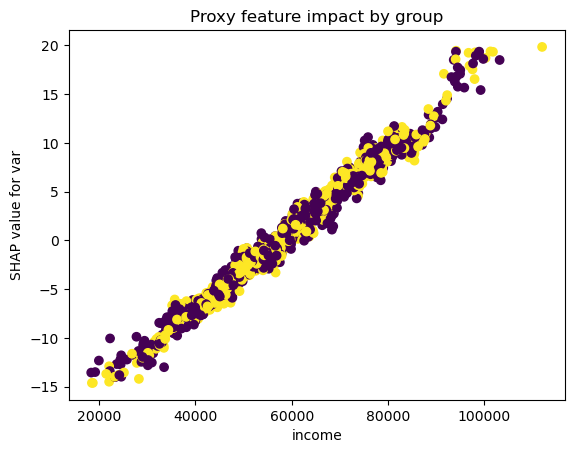

In [14]:
plot_shap("income")

This graph shows that income isn't correlated with group while the otehr graph shows that zipcode_score is because the graph for zipcode_score has two distinct sections for each group while the graph for income has both groups well mixed.  

### If, instead, you were the **reviewer**, what other questions might you ask the person who built this model? Give at least two.

1. What does zipcode_score mean and what is this model predicting?  
2. Are there predictors which potentially decrease the quality of the model's predictions by adding noise to the data?  